In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from data import ModelNet40,download,load_data
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from geomloss import SamplesLoss
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
from matplotlib import pyplot as plt
import pickle
import warnings
import math
import time
from datetime import datetime
from collections import OrderedDict
from scipy.optimize import linear_sum_assignment
from torch import jit
%matplotlib inline
import os
from torch.utils.data import Dataset, TensorDataset
import importlib
from scipy.spatial.transform import Rotation

In [2]:
train_losses = []
test_results_exp = []
test_accs = []

In [3]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 2 every 30 epochs"""
    lrt = lr * (0.5 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lrt

In [4]:
device = torch.device("cuda:6")

In [5]:
data = ModelNet40(num_points=2048, partition='train', gaussian_noise=False,
                       unseen=False, factor=4)
data_test = ModelNet40(num_points=2048, partition='test', gaussian_noise=False,
                       unseen=True, factor=4)
train_loader = DataLoader(data, batch_size=128, shuffle=True, drop_last=True)
test_loader = DataLoader(data_test, batch_size=128, shuffle=True, drop_last=True)
rl_loader = DataLoader(data, batch_size=1, shuffle=True, drop_last=True)

/home/gwu/ConvexICP/data.py:36: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(h5_name)


In [6]:
def npmat2euler(mats, seq='zyx'):
    eulers = []
    for i in range(mats.shape[0]):
        r = Rotation.from_matrix(mats[i])
        eulers.append(r.as_euler(seq, degrees=True))
    return np.asarray(eulers, dtype='float32')

In [7]:
def cal_rt_loss(ra,ta,rb,tb):
    e_pred = npmat2euler(ra.detach().cpu().numpy())
    e_true = np.degrees(rb.detach().cpu().numpy())
    r_loss = F.mse_loss(torch.tensor(e_pred),torch.tensor(e_true)).item()
    t_loss = F.mse_loss(ta,tb).item()
    return r_loss, t_loss

In [8]:
def cal_rt_loss_base(ra,ta,rb,tb):
    r_loss = F.mse_loss(ra,rb).item()
    t_loss = F.mse_loss(ta,tb).item()
    return r_loss, t_loss

In [9]:
class PointNet(nn.Module):
    def __init__(self, emb_dims=512):
        super(PointNet, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1, bias=False)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1, bias=False)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1, bias=False)
        self.conv5 = nn.Conv1d(128, emb_dims, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(emb_dims)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        return x

In [10]:
class CPNet(nn.Module):
    def __init__(self, emb_dims=512,split = 10):
        super(CPNet, self).__init__()
        self.split = split
        self.base_net = PointNet()
        self.loss = SamplesLoss(loss="sinkhorn", p=2, blur=.05)

        
    def forward(self, x1, x2, R, T):
        
        trans = torch.matmul(R, x1) + T.unsqueeze(2)
        emb1 = self.base_net(trans)
        emb2 = self.base_net(x2)
        
        dist = self.loss(emb1,emb2)

        return dist

In [11]:
class CPEvalNet(nn.Module):
    def __init__(self, base_net,batch_size, emb_dims=512):
        super(CPEvalNet, self).__init__()
        self.base_net = PointNet()
        self.base_net.load_state_dict(base_net.state_dict())
        for param in self.base_net.parameters():
            param.requires_grad = False
        self.batch_size = batch_size
        self.rotation = nn.Parameter(torch.Tensor(batch_size,3,3))
        self.translation = nn.Parameter(torch.Tensor(batch_size,3))
        nn.init.kaiming_uniform_(self.rotation, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.translation, a=math.sqrt(5))
        self.loss = SamplesLoss(loss="sinkhorn", p=2, blur=.05)

        
    def forward(self, x1, x2):
        
        trans = torch.matmul(self.rotation, x1) + self.translation.unsqueeze(2)
        emb1 = self.base_net(trans)
        emb2 = self.base_net(x2)
        
        dist = self.loss(emb1,emb2)

        return dist

In [66]:
base_model = torch.load("pert_model_new.mdl").to(device)

In [67]:
def dummy_loss(output, target):
    loss = torch.mean(output)
    return loss

In [58]:
def rt_learning(model, device, src, target, rotation_ab, translation_ab, e_ab, optimizer,criterion,epoch,n_batch = 40):
    r_losses = []
    t_losses = []
    for _ in range(n_batch):
        model.train()
        t1 = datetime.now()
        src = src.to(device)
        target = target.to(device)
        rotation_ab = rotation_ab.to(device)
        translation_ab = translation_ab.to(device)
        optimizer.zero_grad()
        output_train = model(src,target)
        loss = criterion(output_train, target)
        loss.backward()
        optimizer.step()
        r_loss,t_loss = cal_rt_loss(model.rotation, model.translation,e_ab, translation_ab)
        r_losses.append(r_loss)
        t_losses.append(t_loss)
    return r_losses, t_losses

In [59]:
r_losses = []
t_losses = []

In [64]:
for src_rl, target_rl, rotation_ab_rl, translation_ab_rl, rotation_ba_rl, translation_ba_rl,eab,eba in rl_loader:
    model_eval = CPEvalNet(base_model.base_net,len(src_rl)).to(device)
    
    criterion = dummy_loss
    lr = 1e-1
    momentum=0.9
    weight_decay = 5e-4
    optimizer = torch.optim.SGD(model_eval.parameters(), lr,
                                    momentum=momentum,
                                    weight_decay=weight_decay)
    best=0
    
    for epoch in range(1,5000):
        adjust_learning_rate(optimizer, epoch)
        t1 = datetime.now()
        r_batch_loss, t_batch_loss = rt_learning(model_eval, device, src_rl, target_rl, rotation_ab_rl, translation_ab_rl, eab,
                                         optimizer,criterion,epoch,n_batch=40)

        if epoch%1==0:

            print('Train Epoch: {} \tRotation_Loss: {:.6f}\tTranslation_Loss: {:.6f}\tTime: {:.2f}'.format(
                epoch, r_batch_loss[-1],t_batch_loss[-1],(datetime.now()-t1).total_seconds()))
    print("*********************************************")

Train Epoch: 1 	Rotation_Loss: 1681.680664	Translation_Loss: 0.523336	Time: 0.81
Train Epoch: 2 	Rotation_Loss: 1660.265503	Translation_Loss: 0.511426	Time: 0.80
Train Epoch: 3 	Rotation_Loss: 1639.687866	Translation_Loss: 0.499856	Time: 0.79
Train Epoch: 4 	Rotation_Loss: 1622.860352	Translation_Loss: 0.488653	Time: 0.78
Train Epoch: 5 	Rotation_Loss: 1608.259155	Translation_Loss: 0.477805	Time: 0.79
Train Epoch: 6 	Rotation_Loss: 1595.186890	Translation_Loss: 0.467300	Time: 0.79
Train Epoch: 7 	Rotation_Loss: 1584.615234	Translation_Loss: 0.457125	Time: 0.80
Train Epoch: 8 	Rotation_Loss: 1575.998169	Translation_Loss: 0.447270	Time: 0.79
Train Epoch: 9 	Rotation_Loss: 1568.675903	Translation_Loss: 0.437723	Time: 0.79
Train Epoch: 10 	Rotation_Loss: 1564.296875	Translation_Loss: 0.428474	Time: 0.79
Train Epoch: 11 	Rotation_Loss: 1562.201538	Translation_Loss: 0.419513	Time: 0.79
Train Epoch: 12 	Rotation_Loss: 1562.337524	Translation_Loss: 0.410830	Time: 0.78
Train Epoch: 13 	Rotation

Train Epoch: 102 	Rotation_Loss: 2073.030762	Translation_Loss: 0.209653	Time: 0.79
Train Epoch: 103 	Rotation_Loss: 2076.026611	Translation_Loss: 0.209335	Time: 0.79
Train Epoch: 104 	Rotation_Loss: 2079.007812	Translation_Loss: 0.209018	Time: 0.79
Train Epoch: 105 	Rotation_Loss: 2082.039307	Translation_Loss: 0.208702	Time: 0.80
Train Epoch: 106 	Rotation_Loss: 2085.079346	Translation_Loss: 0.208386	Time: 0.79
Train Epoch: 107 	Rotation_Loss: 2088.182373	Translation_Loss: 0.208072	Time: 0.80
Train Epoch: 108 	Rotation_Loss: 2091.272461	Translation_Loss: 0.207759	Time: 0.79
Train Epoch: 109 	Rotation_Loss: 2094.450684	Translation_Loss: 0.207448	Time: 0.80
Train Epoch: 110 	Rotation_Loss: 2097.702881	Translation_Loss: 0.207137	Time: 0.79
Train Epoch: 111 	Rotation_Loss: 2100.805420	Translation_Loss: 0.206827	Time: 0.80
Train Epoch: 112 	Rotation_Loss: 2103.844482	Translation_Loss: 0.206518	Time: 0.80
Train Epoch: 113 	Rotation_Loss: 2106.819336	Translation_Loss: 0.206211	Time: 0.79
Trai

Train Epoch: 201 	Rotation_Loss: 2188.957764	Translation_Loss: 0.197102	Time: 0.79
Train Epoch: 202 	Rotation_Loss: 2189.236084	Translation_Loss: 0.197068	Time: 0.79
Train Epoch: 203 	Rotation_Loss: 2189.515381	Translation_Loss: 0.197033	Time: 0.79
Train Epoch: 204 	Rotation_Loss: 2189.798584	Translation_Loss: 0.196999	Time: 0.78
Train Epoch: 205 	Rotation_Loss: 2190.081299	Translation_Loss: 0.196964	Time: 0.79
Train Epoch: 206 	Rotation_Loss: 2190.359863	Translation_Loss: 0.196930	Time: 0.79
Train Epoch: 207 	Rotation_Loss: 2190.636963	Translation_Loss: 0.196896	Time: 0.79
Train Epoch: 208 	Rotation_Loss: 2190.909180	Translation_Loss: 0.196861	Time: 0.83
Train Epoch: 209 	Rotation_Loss: 2191.175537	Translation_Loss: 0.196827	Time: 0.79
Train Epoch: 210 	Rotation_Loss: 2191.303467	Translation_Loss: 0.196810	Time: 0.79
Train Epoch: 211 	Rotation_Loss: 2191.429688	Translation_Loss: 0.196792	Time: 0.79
Train Epoch: 212 	Rotation_Loss: 2191.557129	Translation_Loss: 0.196775	Time: 0.79
Trai

Train Epoch: 300 	Rotation_Loss: 2198.251953	Translation_Loss: 0.195922	Time: 0.96
Train Epoch: 301 	Rotation_Loss: 2198.275635	Translation_Loss: 0.195920	Time: 0.96
Train Epoch: 302 	Rotation_Loss: 2198.299316	Translation_Loss: 0.195918	Time: 0.93
Train Epoch: 303 	Rotation_Loss: 2198.323486	Translation_Loss: 0.195916	Time: 0.79
Train Epoch: 304 	Rotation_Loss: 2198.347412	Translation_Loss: 0.195913	Time: 0.88
Train Epoch: 305 	Rotation_Loss: 2198.370850	Translation_Loss: 0.195911	Time: 0.79
Train Epoch: 306 	Rotation_Loss: 2198.395264	Translation_Loss: 0.195909	Time: 0.78
Train Epoch: 307 	Rotation_Loss: 2198.418213	Translation_Loss: 0.195907	Time: 0.79
Train Epoch: 308 	Rotation_Loss: 2198.441650	Translation_Loss: 0.195905	Time: 0.80
Train Epoch: 309 	Rotation_Loss: 2198.465088	Translation_Loss: 0.195903	Time: 0.78
Train Epoch: 310 	Rotation_Loss: 2198.488770	Translation_Loss: 0.195901	Time: 0.78
Train Epoch: 311 	Rotation_Loss: 2198.511475	Translation_Loss: 0.195899	Time: 0.79
Trai

Train Epoch: 399 	Rotation_Loss: 2199.335693	Translation_Loss: 0.195814	Time: 0.79
Train Epoch: 400 	Rotation_Loss: 2199.331055	Translation_Loss: 0.195813	Time: 0.78
Train Epoch: 401 	Rotation_Loss: 2199.326416	Translation_Loss: 0.195813	Time: 0.79
Train Epoch: 402 	Rotation_Loss: 2199.321045	Translation_Loss: 0.195812	Time: 0.80
Train Epoch: 403 	Rotation_Loss: 2199.316650	Translation_Loss: 0.195812	Time: 0.79
Train Epoch: 404 	Rotation_Loss: 2199.312256	Translation_Loss: 0.195812	Time: 0.78
Train Epoch: 405 	Rotation_Loss: 2199.307617	Translation_Loss: 0.195811	Time: 0.79
Train Epoch: 406 	Rotation_Loss: 2199.302979	Translation_Loss: 0.195811	Time: 0.80
Train Epoch: 407 	Rotation_Loss: 2199.298584	Translation_Loss: 0.195810	Time: 0.83
Train Epoch: 408 	Rotation_Loss: 2199.293945	Translation_Loss: 0.195810	Time: 0.79
Train Epoch: 409 	Rotation_Loss: 2199.289307	Translation_Loss: 0.195809	Time: 0.79
Train Epoch: 410 	Rotation_Loss: 2199.284912	Translation_Loss: 0.195809	Time: 0.79
Trai

Train Epoch: 498 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.86
Train Epoch: 499 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.95
Train Epoch: 500 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 501 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 502 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.95
Train Epoch: 503 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 504 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 505 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.97
Train Epoch: 506 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 507 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 508 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 509 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Trai

Train Epoch: 597 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 598 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 599 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 600 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 601 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 602 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 603 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 604 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 605 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 606 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 607 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 608 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Trai

Train Epoch: 696 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.94
Train Epoch: 697 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 698 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.86
Train Epoch: 699 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 700 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 701 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.88
Train Epoch: 702 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.85
Train Epoch: 703 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 704 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 705 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 706 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 1.01
Train Epoch: 707 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Trai

Train Epoch: 795 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 796 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 797 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 798 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 799 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 800 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 801 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 802 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 803 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 804 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 805 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 806 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Trai

Train Epoch: 894 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 895 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 896 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 897 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 898 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 899 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 900 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 901 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 902 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 903 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 904 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 905 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Trai

Train Epoch: 993 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 994 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 995 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 996 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 997 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 998 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 999 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.84
Train Epoch: 1000 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 1001 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.84
Train Epoch: 1002 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 1003 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 1004 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82

Train Epoch: 1091 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1092 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 1093 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 1094 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1095 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1096 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 1097 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1098 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 1099 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1100 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 1101 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1102 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 1189 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1190 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 1191 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 1192 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1193 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 1194 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1195 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 1196 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 1197 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1198 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1199 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1200 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 1287 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 1288 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1289 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 1290 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 1291 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1292 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1293 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1294 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1295 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1296 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1297 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 1298 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 1385 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.84
Train Epoch: 1386 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 1387 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 1388 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 1389 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 1390 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 1391 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 1392 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 1393 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 1394 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 1395 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 1396 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 1483 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 1484 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 1485 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 1486 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 1487 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 1488 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 1489 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 1490 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 1491 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.89
Train Epoch: 1492 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 1.03
Train Epoch: 1493 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.95
Train Epoch: 1494 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 1581 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 1582 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1583 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 1584 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1585 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1586 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1587 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 1588 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 1589 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1590 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1591 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1592 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 1679 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 1680 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 1681 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 1682 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 1683 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 1684 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 1685 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 1686 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 1687 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 1688 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 1689 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 1690 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 1777 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1778 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 1779 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1780 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 1781 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 1782 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1783 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 1784 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1785 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 1786 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1787 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1788 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 1875 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 1876 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1877 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1878 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1879 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1880 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1881 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1882 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1883 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.88
Train Epoch: 1884 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 1885 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1886 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 1973 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1974 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 1975 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1976 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 1977 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1978 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1979 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1980 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1981 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1982 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 1983 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 1984 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 2071 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2072 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2073 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2074 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2075 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2076 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2077 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2078 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2079 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2080 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2081 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2082 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 2169 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 2170 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2171 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2172 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2173 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2174 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2175 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2176 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2177 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2178 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2179 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2180 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 2267 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2268 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2269 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2270 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2271 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2272 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2273 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2274 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2275 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2276 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2277 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2278 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 2365 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.97
Train Epoch: 2366 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 2367 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 2368 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 2369 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2370 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2371 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2372 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2373 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2374 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2375 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2376 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 2463 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2464 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2465 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2466 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2467 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2468 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2469 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2470 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2471 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2472 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2473 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2474 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 2561 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 2562 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 2563 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 2564 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 2565 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 2566 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.85
Train Epoch: 2567 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2568 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2569 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2570 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2571 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2572 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 2659 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2660 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2661 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2662 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2663 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2664 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2665 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2666 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2667 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2668 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2669 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2670 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 2757 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2758 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2759 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2760 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2761 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2762 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2763 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2764 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2765 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2766 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2767 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2768 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 2855 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2856 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2857 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2858 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2859 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2860 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2861 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2862 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2863 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2864 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2865 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 2866 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 2953 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2954 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2955 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2956 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2957 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2958 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 2959 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2960 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2961 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 2962 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2963 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 2964 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 3051 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 3052 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 3053 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.97
Train Epoch: 3054 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 3055 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 3056 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 3057 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.94
Train Epoch: 3058 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3059 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3060 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 3061 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3062 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 3149 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3150 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 3151 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3152 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 3153 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 3154 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 3155 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3156 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3157 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3158 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3159 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3160 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 3247 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3248 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3249 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3250 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3251 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3252 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3253 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3254 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3255 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3256 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3257 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 3258 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 3345 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3346 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3347 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3348 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3349 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3350 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 3351 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 3352 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3353 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3354 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 3355 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3356 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 3443 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3444 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3445 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3446 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 3447 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3448 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3449 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3450 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3451 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3452 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3453 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3454 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 3541 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3542 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 3543 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3544 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3545 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3546 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3547 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3548 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3549 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3550 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3551 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3552 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 3639 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3640 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3641 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3642 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 3643 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3644 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 3645 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3646 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3647 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3648 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3649 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3650 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 3737 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 3738 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 3739 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3740 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3741 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3742 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3743 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 3744 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3745 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3746 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 3747 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3748 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 3835 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3836 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3837 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3838 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 3839 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 3840 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3841 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 3842 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 3843 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3844 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3845 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3846 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 3933 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3934 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3935 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 3936 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3937 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3938 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 3939 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 3940 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 3941 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3942 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 3943 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 3944 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 4031 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 4032 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 4033 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 4034 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 4035 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 4036 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 4037 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.84
Train Epoch: 4038 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 4039 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 4040 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.82
Train Epoch: 4041 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.83
Train Epoch: 4042 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 4129 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 4130 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4131 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4132 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4133 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4134 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4135 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4136 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4137 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4138 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4139 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4140 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 4227 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.81
Train Epoch: 4228 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4229 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4230 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4231 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4232 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4233 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4234 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4235 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4236 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4237 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4238 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 4325 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4326 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4327 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4328 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4329 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4330 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4331 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 4332 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 4333 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4334 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4335 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4336 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 4423 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.96
Train Epoch: 4424 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.90
Train Epoch: 4425 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4426 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 4427 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4428 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4429 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4430 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4431 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4432 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4433 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4434 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 4521 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4522 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.84
Train Epoch: 4523 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4524 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4525 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4526 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4527 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4528 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4529 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4530 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 4531 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4532 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 4619 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4620 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4621 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4622 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4623 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4624 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.90
Train Epoch: 4625 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 4626 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4627 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4628 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 4629 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4630 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 4717 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4718 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4719 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4720 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4721 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4722 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4723 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4724 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4725 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4726 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4727 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4728 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 4815 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4816 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4817 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4818 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4819 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4820 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 4821 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 4822 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4823 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 4824 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4825 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.88
Train Epoch: 4826 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 4913 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4914 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4915 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4916 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4917 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 4918 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4919 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4920 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.80
Train Epoch: 4921 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.79
Train Epoch: 4922 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 4923 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Time: 0.78
Train Epoch: 4924 	Rotation_Loss: 2199.293457	Translation_Loss: 0.195805	Tim

Train Epoch: 12 	Rotation_Loss: 7305.334473	Translation_Loss: 0.081101	Time: 0.77
Train Epoch: 13 	Rotation_Loss: 7298.351074	Translation_Loss: 0.079890	Time: 0.77
Train Epoch: 14 	Rotation_Loss: 7289.273438	Translation_Loss: 0.078719	Time: 0.76
Train Epoch: 15 	Rotation_Loss: 7278.525879	Translation_Loss: 0.077586	Time: 0.76
Train Epoch: 16 	Rotation_Loss: 7271.164551	Translation_Loss: 0.076490	Time: 0.76
Train Epoch: 17 	Rotation_Loss: 7264.791504	Translation_Loss: 0.075430	Time: 0.77
Train Epoch: 18 	Rotation_Loss: 7251.825684	Translation_Loss: 0.074404	Time: 0.75
Train Epoch: 19 	Rotation_Loss: 7241.488770	Translation_Loss: 0.073411	Time: 0.75
Train Epoch: 20 	Rotation_Loss: 7234.420410	Translation_Loss: 0.072450	Time: 0.76
Train Epoch: 21 	Rotation_Loss: 7226.937500	Translation_Loss: 0.071520	Time: 0.77
Train Epoch: 22 	Rotation_Loss: 7224.267090	Translation_Loss: 0.070619	Time: 0.75
Train Epoch: 23 	Rotation_Loss: 7221.779785	Translation_Loss: 0.069748	Time: 0.78
Train Epoch: 24 

Train Epoch: 112 	Rotation_Loss: 7235.035156	Translation_Loss: 0.052657	Time: 0.76
Train Epoch: 113 	Rotation_Loss: 7235.407715	Translation_Loss: 0.052617	Time: 0.76
Train Epoch: 114 	Rotation_Loss: 7235.866699	Translation_Loss: 0.052576	Time: 0.76
Train Epoch: 115 	Rotation_Loss: 7236.136719	Translation_Loss: 0.052536	Time: 0.75
Train Epoch: 116 	Rotation_Loss: 7236.574707	Translation_Loss: 0.052496	Time: 0.79
Train Epoch: 117 	Rotation_Loss: 7236.937500	Translation_Loss: 0.052456	Time: 0.84
Train Epoch: 118 	Rotation_Loss: 7237.269043	Translation_Loss: 0.052416	Time: 0.76
Train Epoch: 119 	Rotation_Loss: 7237.722656	Translation_Loss: 0.052376	Time: 0.76
Train Epoch: 120 	Rotation_Loss: 7237.843262	Translation_Loss: 0.052356	Time: 0.75
Train Epoch: 121 	Rotation_Loss: 7237.967285	Translation_Loss: 0.052336	Time: 0.77
Train Epoch: 122 	Rotation_Loss: 7238.139160	Translation_Loss: 0.052317	Time: 0.76
Train Epoch: 123 	Rotation_Loss: 7238.321777	Translation_Loss: 0.052297	Time: 0.77
Trai

Train Epoch: 211 	Rotation_Loss: 7247.503906	Translation_Loss: 0.051378	Time: 0.76
Train Epoch: 212 	Rotation_Loss: 7247.526855	Translation_Loss: 0.051375	Time: 0.77
Train Epoch: 213 	Rotation_Loss: 7247.551270	Translation_Loss: 0.051373	Time: 0.78
Train Epoch: 214 	Rotation_Loss: 7247.575684	Translation_Loss: 0.051371	Time: 0.77
Train Epoch: 215 	Rotation_Loss: 7247.603027	Translation_Loss: 0.051369	Time: 0.77
Train Epoch: 216 	Rotation_Loss: 7247.620605	Translation_Loss: 0.051366	Time: 0.77
Train Epoch: 217 	Rotation_Loss: 7247.646484	Translation_Loss: 0.051364	Time: 0.77
Train Epoch: 218 	Rotation_Loss: 7247.674316	Translation_Loss: 0.051362	Time: 0.76
Train Epoch: 219 	Rotation_Loss: 7247.693848	Translation_Loss: 0.051359	Time: 0.76
Train Epoch: 220 	Rotation_Loss: 7247.718750	Translation_Loss: 0.051357	Time: 0.76
Train Epoch: 221 	Rotation_Loss: 7247.750000	Translation_Loss: 0.051355	Time: 0.77
Train Epoch: 222 	Rotation_Loss: 7247.768066	Translation_Loss: 0.051353	Time: 0.76
Trai

Train Epoch: 310 	Rotation_Loss: 7248.758301	Translation_Loss: 0.051261	Time: 0.95
Train Epoch: 311 	Rotation_Loss: 7248.759766	Translation_Loss: 0.051261	Time: 0.95
Train Epoch: 312 	Rotation_Loss: 7248.760254	Translation_Loss: 0.051260	Time: 0.96
Train Epoch: 313 	Rotation_Loss: 7248.763184	Translation_Loss: 0.051260	Time: 0.96
Train Epoch: 314 	Rotation_Loss: 7248.767090	Translation_Loss: 0.051260	Time: 0.96
Train Epoch: 315 	Rotation_Loss: 7248.770996	Translation_Loss: 0.051260	Time: 0.95
Train Epoch: 316 	Rotation_Loss: 7248.774902	Translation_Loss: 0.051259	Time: 0.96
Train Epoch: 317 	Rotation_Loss: 7248.774902	Translation_Loss: 0.051259	Time: 0.96
Train Epoch: 318 	Rotation_Loss: 7248.778809	Translation_Loss: 0.051259	Time: 0.95
Train Epoch: 319 	Rotation_Loss: 7248.782715	Translation_Loss: 0.051258	Time: 0.95
Train Epoch: 320 	Rotation_Loss: 7248.787109	Translation_Loss: 0.051258	Time: 0.87
Train Epoch: 321 	Rotation_Loss: 7248.787598	Translation_Loss: 0.051258	Time: 0.79
Trai

Train Epoch: 409 	Rotation_Loss: 7248.822754	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 410 	Rotation_Loss: 7248.821777	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 411 	Rotation_Loss: 7248.819824	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 412 	Rotation_Loss: 7248.820312	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 413 	Rotation_Loss: 7248.820312	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 414 	Rotation_Loss: 7248.820312	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 415 	Rotation_Loss: 7248.818848	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 416 	Rotation_Loss: 7248.817871	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 417 	Rotation_Loss: 7248.818359	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 418 	Rotation_Loss: 7248.819824	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 419 	Rotation_Loss: 7248.817871	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 420 	Rotation_Loss: 7248.817871	Translation_Loss: 0.051249	Time: 0.76
Trai

Train Epoch: 508 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 509 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 510 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 511 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 512 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 513 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 514 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 515 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 516 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 517 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 518 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 519 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Trai

Train Epoch: 607 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 608 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 609 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 610 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 611 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 612 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 613 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.79
Train Epoch: 614 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 615 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.79
Train Epoch: 616 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 617 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 618 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Trai

Train Epoch: 706 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 707 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 708 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 709 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 710 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 711 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 712 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 713 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 714 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 715 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 716 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 717 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Trai

Train Epoch: 805 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 806 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 807 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 808 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 809 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 810 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 811 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 812 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 813 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 814 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 815 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 816 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Trai

Train Epoch: 904 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 905 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 906 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 907 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 908 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 909 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 910 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 911 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 912 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 913 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 914 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 915 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Trai

Train Epoch: 1003 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1004 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1005 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1006 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1007 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1008 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1009 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1010 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 1011 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1012 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1013 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1014 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 1101 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1102 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1103 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1104 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1105 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1106 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1107 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1108 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1109 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1110 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1111 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1112 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 1199 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1200 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1201 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1202 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1203 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1204 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1205 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1206 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1207 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.79
Train Epoch: 1208 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1209 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1210 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 1297 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 1298 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 1299 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 1300 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 1301 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 1302 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.81
Train Epoch: 1303 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 1304 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 1305 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 1306 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.81
Train Epoch: 1307 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 1308 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 1395 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.81
Train Epoch: 1396 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 1397 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.81
Train Epoch: 1398 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 1399 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 1400 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.81
Train Epoch: 1401 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.79
Train Epoch: 1402 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.88
Train Epoch: 1403 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 1.00
Train Epoch: 1404 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.90
Train Epoch: 1405 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.91
Train Epoch: 1406 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 1493 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1494 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1495 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1496 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1497 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1498 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.79
Train Epoch: 1499 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1500 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1501 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1502 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1503 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1504 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 1591 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1592 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1593 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1594 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1595 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1596 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1597 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1598 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1599 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1600 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1601 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1602 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 1689 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1690 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1691 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1692 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1693 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1694 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1695 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1696 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1697 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1698 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1699 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1700 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 1787 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1788 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1789 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1790 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1791 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1792 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1793 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1794 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1795 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1796 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1797 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1798 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 1885 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1886 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1887 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1888 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 1889 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1890 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1891 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1892 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1893 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1894 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1895 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1896 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 1983 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 1984 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1985 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1986 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1987 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 1988 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1989 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1990 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1991 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1992 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 1993 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 1994 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 2081 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2082 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2083 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 2084 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2085 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2086 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2087 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2088 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 2089 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2090 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2091 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2092 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 2179 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 2180 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2181 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2182 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2183 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2184 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2185 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2186 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2187 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2188 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 2189 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2190 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 2277 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2278 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 2279 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2280 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2281 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2282 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2283 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2284 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2285 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2286 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2287 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2288 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 2375 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2376 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2377 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2378 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2379 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2380 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2381 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2382 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2383 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2384 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.89
Train Epoch: 2385 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 2386 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 2473 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2474 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 2475 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2476 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2477 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2478 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2479 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2480 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2481 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2482 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 2483 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2484 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 2571 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2572 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2573 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 2574 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2575 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 2576 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2577 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2578 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2579 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2580 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2581 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 2582 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 2669 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2670 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2671 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 2672 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2673 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2674 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2675 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2676 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2677 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2678 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2679 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2680 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 2767 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2768 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2769 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2770 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2771 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2772 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 2773 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2774 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2775 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 2776 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2777 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2778 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 2865 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.79
Train Epoch: 2866 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2867 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2868 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2869 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 2870 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2871 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2872 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2873 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2874 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 2875 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 2876 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 2963 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 2964 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 2965 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 2966 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 2967 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 2968 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.94
Train Epoch: 2969 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.90
Train Epoch: 2970 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.91
Train Epoch: 2971 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.91
Train Epoch: 2972 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.91
Train Epoch: 2973 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.91
Train Epoch: 2974 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 3061 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.81
Train Epoch: 3062 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 3063 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.85
Train Epoch: 3064 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 1.00
Train Epoch: 3065 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.92
Train Epoch: 3066 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.90
Train Epoch: 3067 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.92
Train Epoch: 3068 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.90
Train Epoch: 3069 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.92
Train Epoch: 3070 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.91
Train Epoch: 3071 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.91
Train Epoch: 3072 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 3159 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3160 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3161 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3162 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3163 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3164 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 3165 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3166 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 3167 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3168 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3169 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 3170 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 3257 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3258 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3259 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3260 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3261 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 3262 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3263 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3264 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3265 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3266 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3267 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3268 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 3355 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3356 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3357 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3358 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3359 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 3360 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3361 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.79
Train Epoch: 3362 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.85
Train Epoch: 3363 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.79
Train Epoch: 3364 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3365 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 3366 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 3453 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3454 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3455 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3456 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3457 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 3458 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3459 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3460 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3461 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3462 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3463 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3464 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 3551 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3552 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3553 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3554 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3555 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3556 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 3557 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3558 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3559 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3560 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3561 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3562 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 3649 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3650 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3651 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3652 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3653 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3654 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3655 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3656 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3657 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3658 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 3659 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3660 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 3747 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3748 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3749 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3750 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3751 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3752 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3753 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3754 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3755 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.79
Train Epoch: 3756 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3757 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3758 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 3845 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 3846 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 3847 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 3848 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.79
Train Epoch: 3849 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.79
Train Epoch: 3850 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.81
Train Epoch: 3851 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 3852 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.80
Train Epoch: 3853 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.81
Train Epoch: 3854 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.81
Train Epoch: 3855 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.81
Train Epoch: 3856 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 3943 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3944 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3945 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3946 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 3947 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.79
Train Epoch: 3948 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3949 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 3950 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3951 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3952 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 3953 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 3954 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 4041 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4042 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4043 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 4044 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4045 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4046 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4047 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4048 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4049 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4050 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 4051 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4052 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 4139 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4140 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 4141 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4142 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4143 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4144 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4145 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4146 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4147 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4148 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4149 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4150 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 4237 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4238 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4239 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4240 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4241 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 4242 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4243 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4244 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4245 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4246 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4247 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4248 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 4335 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.91
Train Epoch: 4336 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.91
Train Epoch: 4337 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.92
Train Epoch: 4338 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.92
Train Epoch: 4339 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.92
Train Epoch: 4340 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.91
Train Epoch: 4341 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.92
Train Epoch: 4342 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.91
Train Epoch: 4343 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.91
Train Epoch: 4344 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.92
Train Epoch: 4345 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.92
Train Epoch: 4346 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 4555 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 4556 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4557 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4558 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4559 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 4560 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.85
Train Epoch: 4561 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4562 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4563 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4564 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 4565 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 4566 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 4653 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 4654 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4655 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4656 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4657 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4658 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 4659 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4660 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 4661 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 4662 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 4663 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 4664 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 4751 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 4752 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4753 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 4754 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4755 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4756 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4757 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4758 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 4759 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 4760 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4761 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 4762 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 4849 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.92
Train Epoch: 4850 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.90
Train Epoch: 4851 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.91
Train Epoch: 4852 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.91
Train Epoch: 4853 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.92
Train Epoch: 4854 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.91
Train Epoch: 4855 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.92
Train Epoch: 4856 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.92
Train Epoch: 4857 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.92
Train Epoch: 4858 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.92
Train Epoch: 4859 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.91
Train Epoch: 4860 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 4947 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.78
Train Epoch: 4948 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.77
Train Epoch: 4949 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4950 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4951 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4952 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4953 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4954 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4955 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.75
Train Epoch: 4956 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4957 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Time: 0.76
Train Epoch: 4958 	Rotation_Loss: 7248.832031	Translation_Loss: 0.051249	Tim

Train Epoch: 47 	Rotation_Loss: 4927.103027	Translation_Loss: 0.011151	Time: 0.83
Train Epoch: 48 	Rotation_Loss: 4920.079102	Translation_Loss: 0.010803	Time: 0.80
Train Epoch: 49 	Rotation_Loss: 4913.742676	Translation_Loss: 0.010467	Time: 0.79
Train Epoch: 50 	Rotation_Loss: 4908.946289	Translation_Loss: 0.010143	Time: 0.80
Train Epoch: 51 	Rotation_Loss: 4898.954590	Translation_Loss: 0.009830	Time: 0.80
Train Epoch: 52 	Rotation_Loss: 4883.505859	Translation_Loss: 0.009528	Time: 0.78
Train Epoch: 53 	Rotation_Loss: 4872.625488	Translation_Loss: 0.009236	Time: 0.79
Train Epoch: 54 	Rotation_Loss: 4860.807129	Translation_Loss: 0.008955	Time: 0.80
Train Epoch: 55 	Rotation_Loss: 4849.767090	Translation_Loss: 0.008684	Time: 0.79
Train Epoch: 56 	Rotation_Loss: 4843.255371	Translation_Loss: 0.008423	Time: 0.79
Train Epoch: 57 	Rotation_Loss: 4840.777832	Translation_Loss: 0.008171	Time: 0.78
Train Epoch: 58 	Rotation_Loss: 4839.554199	Translation_Loss: 0.007929	Time: 0.79
Train Epoch: 59 

Train Epoch: 147 	Rotation_Loss: 4926.524902	Translation_Loss: 0.004213	Time: 0.80
Train Epoch: 148 	Rotation_Loss: 4926.051270	Translation_Loss: 0.004206	Time: 0.78
Train Epoch: 149 	Rotation_Loss: 4925.655762	Translation_Loss: 0.004199	Time: 0.80
Train Epoch: 150 	Rotation_Loss: 4925.779297	Translation_Loss: 0.004195	Time: 0.79
Train Epoch: 151 	Rotation_Loss: 4925.923340	Translation_Loss: 0.004192	Time: 0.79
Train Epoch: 152 	Rotation_Loss: 4926.054688	Translation_Loss: 0.004188	Time: 0.80
Train Epoch: 153 	Rotation_Loss: 4926.172363	Translation_Loss: 0.004184	Time: 0.80
Train Epoch: 154 	Rotation_Loss: 4925.947266	Translation_Loss: 0.004181	Time: 0.78
Train Epoch: 155 	Rotation_Loss: 4925.834473	Translation_Loss: 0.004177	Time: 0.79
Train Epoch: 156 	Rotation_Loss: 4925.821777	Translation_Loss: 0.004174	Time: 0.81
Train Epoch: 157 	Rotation_Loss: 4925.937012	Translation_Loss: 0.004170	Time: 0.79
Train Epoch: 158 	Rotation_Loss: 4926.091309	Translation_Loss: 0.004167	Time: 0.79
Trai

Train Epoch: 246 	Rotation_Loss: 4936.088379	Translation_Loss: 0.004031	Time: 0.80
Train Epoch: 247 	Rotation_Loss: 4936.140137	Translation_Loss: 0.004031	Time: 0.79
Train Epoch: 248 	Rotation_Loss: 4936.191406	Translation_Loss: 0.004030	Time: 0.78
Train Epoch: 249 	Rotation_Loss: 4936.243652	Translation_Loss: 0.004030	Time: 0.78
Train Epoch: 250 	Rotation_Loss: 4936.295410	Translation_Loss: 0.004030	Time: 0.79
Train Epoch: 251 	Rotation_Loss: 4936.344238	Translation_Loss: 0.004029	Time: 0.80
Train Epoch: 252 	Rotation_Loss: 4936.391113	Translation_Loss: 0.004029	Time: 0.79
Train Epoch: 253 	Rotation_Loss: 4936.440918	Translation_Loss: 0.004029	Time: 0.79
Train Epoch: 254 	Rotation_Loss: 4936.488770	Translation_Loss: 0.004028	Time: 0.79
Train Epoch: 255 	Rotation_Loss: 4936.538574	Translation_Loss: 0.004028	Time: 0.79
Train Epoch: 256 	Rotation_Loss: 4936.587402	Translation_Loss: 0.004028	Time: 0.80
Train Epoch: 257 	Rotation_Loss: 4936.634766	Translation_Loss: 0.004027	Time: 0.79
Trai

Train Epoch: 345 	Rotation_Loss: 4938.636230	Translation_Loss: 0.004015	Time: 0.97
Train Epoch: 346 	Rotation_Loss: 4938.638672	Translation_Loss: 0.004015	Time: 0.85
Train Epoch: 347 	Rotation_Loss: 4938.640625	Translation_Loss: 0.004015	Time: 0.80
Train Epoch: 348 	Rotation_Loss: 4938.644043	Translation_Loss: 0.004015	Time: 0.80
Train Epoch: 349 	Rotation_Loss: 4938.647949	Translation_Loss: 0.004015	Time: 0.79
Train Epoch: 350 	Rotation_Loss: 4938.651855	Translation_Loss: 0.004015	Time: 0.79
Train Epoch: 351 	Rotation_Loss: 4938.655762	Translation_Loss: 0.004015	Time: 0.79
Train Epoch: 352 	Rotation_Loss: 4938.658691	Translation_Loss: 0.004014	Time: 0.79
Train Epoch: 353 	Rotation_Loss: 4938.660645	Translation_Loss: 0.004014	Time: 0.79
Train Epoch: 354 	Rotation_Loss: 4938.663574	Translation_Loss: 0.004014	Time: 0.80
Train Epoch: 355 	Rotation_Loss: 4938.665527	Translation_Loss: 0.004014	Time: 0.80
Train Epoch: 356 	Rotation_Loss: 4938.667480	Translation_Loss: 0.004014	Time: 0.80
Trai

Train Epoch: 444 	Rotation_Loss: 4939.034668	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 445 	Rotation_Loss: 4939.032715	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 446 	Rotation_Loss: 4939.029785	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 447 	Rotation_Loss: 4939.027344	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 448 	Rotation_Loss: 4939.025391	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 449 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.82
Train Epoch: 450 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 451 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 452 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 453 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 454 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 455 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Trai

Train Epoch: 543 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 544 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 545 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.91
Train Epoch: 546 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 547 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 548 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 549 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 550 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 551 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 552 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 553 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 554 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Trai

Train Epoch: 642 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 643 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 644 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.77
Train Epoch: 645 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 646 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 647 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 648 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 649 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 650 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 651 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 652 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 653 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Trai

Train Epoch: 741 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 742 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 743 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 744 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 745 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 746 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 747 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 748 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 749 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 750 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 751 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 752 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Trai

Train Epoch: 840 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 841 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 842 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 843 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 844 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 845 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 846 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 847 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.91
Train Epoch: 848 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.95
Train Epoch: 849 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.96
Train Epoch: 850 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.96
Train Epoch: 851 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.96
Trai

Train Epoch: 939 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 940 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 941 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 942 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 943 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 944 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 945 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 946 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 947 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 948 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 949 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.87
Train Epoch: 950 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.83
Trai

Train Epoch: 1038 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1039 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1040 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1041 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1042 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1043 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1044 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1045 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1046 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1047 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1048 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1049 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Tim

Train Epoch: 1136 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1137 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1138 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1139 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1140 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1141 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1142 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1143 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1144 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1145 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1146 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1147 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Tim

Train Epoch: 1234 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1235 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1236 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1237 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1238 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1239 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1240 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1241 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1242 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1243 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1244 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1245 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Tim

Train Epoch: 1332 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.83
Train Epoch: 1333 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.82
Train Epoch: 1334 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.81
Train Epoch: 1335 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.81
Train Epoch: 1336 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.84
Train Epoch: 1337 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.82
Train Epoch: 1338 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.83
Train Epoch: 1339 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.83
Train Epoch: 1340 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.83
Train Epoch: 1341 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.82
Train Epoch: 1342 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.83
Train Epoch: 1343 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Tim

Train Epoch: 1430 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1431 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1432 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 1433 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1434 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1435 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1436 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 1437 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 1438 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1439 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.83
Train Epoch: 1440 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1441 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Tim

Train Epoch: 1528 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1529 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1530 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1531 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1532 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1533 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1534 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1535 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1536 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1537 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1538 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1539 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Tim

Train Epoch: 1626 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1627 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1628 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1629 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1630 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1631 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1632 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1633 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1634 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1635 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1636 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1637 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Tim

Train Epoch: 1724 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1725 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1726 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1727 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1728 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1729 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1730 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 1731 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1732 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1733 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1734 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1735 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Tim

Train Epoch: 1822 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 1823 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1824 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1825 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1826 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1827 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1828 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 1829 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1830 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1831 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.82
Train Epoch: 1832 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1833 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Tim

Train Epoch: 1920 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1921 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 1922 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1923 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 1924 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 1925 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.81
Train Epoch: 1926 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1927 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 1928 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1929 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 1930 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 1931 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Tim

Train Epoch: 2018 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2019 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2020 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2021 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2022 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2023 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2024 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2025 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2026 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2027 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2028 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2029 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Tim

Train Epoch: 2116 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2117 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2118 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2119 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2120 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2121 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2122 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2123 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2124 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2125 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2126 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2127 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Tim

Train Epoch: 2214 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2215 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2216 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2217 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2218 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.82
Train Epoch: 2219 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.81
Train Epoch: 2220 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2221 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.82
Train Epoch: 2222 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2223 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.81
Train Epoch: 2224 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2225 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Tim

Train Epoch: 2312 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 2313 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2314 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2315 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2316 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2317 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2318 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2319 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2320 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2321 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 2322 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2323 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Tim

Train Epoch: 2410 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2411 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2412 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2413 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2414 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2415 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.78
Train Epoch: 2416 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.81
Train Epoch: 2417 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.79
Train Epoch: 2418 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2419 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2420 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Time: 0.80
Train Epoch: 2421 	Rotation_Loss: 4939.022949	Translation_Loss: 0.004013	Tim

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 2590 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2591 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 2592 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.78
Train Epoch: 2593 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2594 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 2595 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2596 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2597 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2598 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 2599 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 2600 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2601 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 2687 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2688 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 2689 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2690 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 2691 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2692 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2693 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2694 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 2695 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2696 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2697 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2698 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 2784 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2785 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2786 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2787 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.79
Train Epoch: 2788 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2789 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2790 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2791 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2792 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2793 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 2794 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 2795 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 2881 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 2882 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.81
Train Epoch: 2883 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 2884 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 2885 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 2886 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 2887 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 2888 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.81
Train Epoch: 2889 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.92
Train Epoch: 2890 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.93
Train Epoch: 2891 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 2892 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 2978 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.81
Train Epoch: 2979 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 2980 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 2981 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 2982 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 2983 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 2984 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.79
Train Epoch: 2985 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 2986 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 2987 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.81
Train Epoch: 2988 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.79
Train Epoch: 2989 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 3075 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3076 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3077 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 3078 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 3079 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3080 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3081 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3082 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3083 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3084 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3085 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 3086 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 3172 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3173 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3174 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3175 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3176 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3177 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.74
Train Epoch: 3178 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3179 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3180 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3181 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3182 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3183 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 3269 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3270 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3271 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3272 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3273 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3274 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3275 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3276 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3277 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3278 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3279 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 3280 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 3366 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.82
Train Epoch: 3367 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.82
Train Epoch: 3368 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.82
Train Epoch: 3369 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.82
Train Epoch: 3370 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.83
Train Epoch: 3371 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.82
Train Epoch: 3372 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.82
Train Epoch: 3373 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.83
Train Epoch: 3374 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.83
Train Epoch: 3375 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.83
Train Epoch: 3376 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.82
Train Epoch: 3377 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 3463 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.92
Train Epoch: 3464 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.92
Train Epoch: 3465 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.91
Train Epoch: 3466 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.90
Train Epoch: 3467 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.91
Train Epoch: 3468 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.92
Train Epoch: 3469 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.91
Train Epoch: 3470 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.91
Train Epoch: 3471 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.92
Train Epoch: 3472 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.91
Train Epoch: 3473 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.91
Train Epoch: 3474 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 3560 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3561 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3562 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3563 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 3564 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3565 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3566 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3567 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3568 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3569 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3570 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3571 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 3657 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3658 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3659 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3660 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3661 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3662 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3663 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3664 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3665 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3666 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3667 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3668 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 3754 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3755 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.79
Train Epoch: 3756 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3757 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 3758 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3759 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3760 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3761 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.78
Train Epoch: 3762 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3763 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3764 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3765 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 3851 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3852 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3853 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.78
Train Epoch: 3854 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3855 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3856 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3857 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3858 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 3859 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3860 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3861 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.79
Train Epoch: 3862 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 3948 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3949 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3950 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 3951 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 3952 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3953 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3954 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3955 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3956 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3957 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3958 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 3959 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 4045 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4046 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4047 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4048 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 4049 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4050 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 4051 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4052 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4053 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 4054 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4055 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4056 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 4142 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4143 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4144 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 4145 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4146 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4147 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4148 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4149 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4150 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4151 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4152 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4153 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 4239 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4240 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4241 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4242 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4243 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4244 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4245 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 4246 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4247 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4248 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4249 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.79
Train Epoch: 4250 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 4336 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.91
Train Epoch: 4337 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.92
Train Epoch: 4338 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.92
Train Epoch: 4339 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.92
Train Epoch: 4340 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.90
Train Epoch: 4341 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.91
Train Epoch: 4342 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.92
Train Epoch: 4343 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4344 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4345 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.78
Train Epoch: 4346 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4347 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 4433 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4434 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4435 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4436 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4437 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4438 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.79
Train Epoch: 4439 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4440 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.78
Train Epoch: 4441 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4442 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4443 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4444 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 4530 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4531 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4532 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 4533 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 4534 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4535 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4536 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4537 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4538 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4539 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.78
Train Epoch: 4540 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4541 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 4627 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 4628 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4629 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4630 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4631 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4632 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4633 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4634 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4635 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4636 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4637 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 4638 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 4724 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 4725 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4726 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.80
Train Epoch: 4727 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.93
Train Epoch: 4728 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.91
Train Epoch: 4729 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.91
Train Epoch: 4730 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.92
Train Epoch: 4731 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.93
Train Epoch: 4732 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.91
Train Epoch: 4733 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.91
Train Epoch: 4734 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.92
Train Epoch: 4735 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 4821 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 4822 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4823 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4824 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4825 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4826 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.78
Train Epoch: 4827 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4828 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4829 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4830 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4831 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 4832 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 4918 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4919 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4920 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4921 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 4922 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 4923 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4924 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4925 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.77
Train Epoch: 4926 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.76
Train Epoch: 4927 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 4928 	Rotation_Loss: 10663.841797	Translation_Loss: 0.129261	Time: 0.75
Train Epoch: 4929 	Rotation_Loss: 10663.841797	Translation_Loss: 

Train Epoch: 16 	Rotation_Loss: 8139.648438	Translation_Loss: 0.138950	Time: 0.79
Train Epoch: 17 	Rotation_Loss: 8124.416504	Translation_Loss: 0.136782	Time: 0.79
Train Epoch: 18 	Rotation_Loss: 8115.898926	Translation_Loss: 0.134698	Time: 0.79
Train Epoch: 19 	Rotation_Loss: 8111.437012	Translation_Loss: 0.132695	Time: 0.80
Train Epoch: 20 	Rotation_Loss: 8115.068359	Translation_Loss: 0.130768	Time: 0.78
Train Epoch: 21 	Rotation_Loss: 8124.382812	Translation_Loss: 0.128916	Time: 0.79
Train Epoch: 22 	Rotation_Loss: 8135.023438	Translation_Loss: 0.127136	Time: 0.79
Train Epoch: 23 	Rotation_Loss: 8150.160645	Translation_Loss: 0.125424	Time: 0.79
Train Epoch: 24 	Rotation_Loss: 8168.066406	Translation_Loss: 0.123778	Time: 0.80
Train Epoch: 25 	Rotation_Loss: 8188.466309	Translation_Loss: 0.122195	Time: 0.80
Train Epoch: 26 	Rotation_Loss: 8212.022461	Translation_Loss: 0.120674	Time: 0.80
Train Epoch: 27 	Rotation_Loss: 8235.790039	Translation_Loss: 0.119210	Time: 0.78
Train Epoch: 28 

Train Epoch: 116 	Rotation_Loss: 9301.958008	Translation_Loss: 0.094878	Time: 0.80
Train Epoch: 117 	Rotation_Loss: 9307.070312	Translation_Loss: 0.094818	Time: 0.78
Train Epoch: 118 	Rotation_Loss: 9312.175781	Translation_Loss: 0.094758	Time: 0.84
Train Epoch: 119 	Rotation_Loss: 9317.429688	Translation_Loss: 0.094698	Time: 0.85
Train Epoch: 120 	Rotation_Loss: 9320.092773	Translation_Loss: 0.094668	Time: 0.79
Train Epoch: 121 	Rotation_Loss: 9322.906250	Translation_Loss: 0.094639	Time: 0.79
Train Epoch: 122 	Rotation_Loss: 9325.803711	Translation_Loss: 0.094609	Time: 0.80
Train Epoch: 123 	Rotation_Loss: 9328.783203	Translation_Loss: 0.094579	Time: 0.79
Train Epoch: 124 	Rotation_Loss: 9331.829102	Translation_Loss: 0.094550	Time: 0.79
Train Epoch: 125 	Rotation_Loss: 9334.948242	Translation_Loss: 0.094521	Time: 0.79
Train Epoch: 126 	Rotation_Loss: 9338.042969	Translation_Loss: 0.094491	Time: 0.81
Train Epoch: 127 	Rotation_Loss: 9341.267578	Translation_Loss: 0.094462	Time: 0.80
Trai

Train Epoch: 215 	Rotation_Loss: 9463.906250	Translation_Loss: 0.093207	Time: 0.81
Train Epoch: 216 	Rotation_Loss: 9464.168945	Translation_Loss: 0.093203	Time: 0.78
Train Epoch: 217 	Rotation_Loss: 9464.430664	Translation_Loss: 0.093200	Time: 0.80
Train Epoch: 218 	Rotation_Loss: 9464.692383	Translation_Loss: 0.093197	Time: 0.79
Train Epoch: 219 	Rotation_Loss: 9464.958008	Translation_Loss: 0.093193	Time: 0.80
Train Epoch: 220 	Rotation_Loss: 9465.231445	Translation_Loss: 0.093190	Time: 0.79
Train Epoch: 221 	Rotation_Loss: 9465.514648	Translation_Loss: 0.093187	Time: 0.78
Train Epoch: 222 	Rotation_Loss: 9465.800781	Translation_Loss: 0.093184	Time: 0.79
Train Epoch: 223 	Rotation_Loss: 9466.088867	Translation_Loss: 0.093181	Time: 0.78
Train Epoch: 224 	Rotation_Loss: 9466.375000	Translation_Loss: 0.093177	Time: 0.79
Train Epoch: 225 	Rotation_Loss: 9466.663086	Translation_Loss: 0.093174	Time: 0.79
Train Epoch: 226 	Rotation_Loss: 9466.954102	Translation_Loss: 0.093171	Time: 0.82
Trai

Train Epoch: 314 	Rotation_Loss: 9477.315430	Translation_Loss: 0.093050	Time: 0.78
Train Epoch: 315 	Rotation_Loss: 9477.351562	Translation_Loss: 0.093049	Time: 0.78
Train Epoch: 316 	Rotation_Loss: 9477.387695	Translation_Loss: 0.093049	Time: 0.79
Train Epoch: 317 	Rotation_Loss: 9477.423828	Translation_Loss: 0.093048	Time: 0.79
Train Epoch: 318 	Rotation_Loss: 9477.459961	Translation_Loss: 0.093048	Time: 0.80
Train Epoch: 319 	Rotation_Loss: 9477.496094	Translation_Loss: 0.093048	Time: 0.79
Train Epoch: 320 	Rotation_Loss: 9477.532227	Translation_Loss: 0.093047	Time: 0.78
Train Epoch: 321 	Rotation_Loss: 9477.569336	Translation_Loss: 0.093047	Time: 0.79
Train Epoch: 322 	Rotation_Loss: 9477.604492	Translation_Loss: 0.093046	Time: 0.79
Train Epoch: 323 	Rotation_Loss: 9477.640625	Translation_Loss: 0.093046	Time: 0.79
Train Epoch: 324 	Rotation_Loss: 9477.676758	Translation_Loss: 0.093045	Time: 0.80
Train Epoch: 325 	Rotation_Loss: 9477.713867	Translation_Loss: 0.093045	Time: 0.78
Trai

Train Epoch: 413 	Rotation_Loss: 9478.702148	Translation_Loss: 0.093033	Time: 0.79
Train Epoch: 414 	Rotation_Loss: 9478.710938	Translation_Loss: 0.093033	Time: 0.80
Train Epoch: 415 	Rotation_Loss: 9478.720703	Translation_Loss: 0.093033	Time: 0.79
Train Epoch: 416 	Rotation_Loss: 9478.729492	Translation_Loss: 0.093033	Time: 0.78
Train Epoch: 417 	Rotation_Loss: 9478.738281	Translation_Loss: 0.093032	Time: 0.79
Train Epoch: 418 	Rotation_Loss: 9478.749023	Translation_Loss: 0.093032	Time: 0.80
Train Epoch: 419 	Rotation_Loss: 9478.756836	Translation_Loss: 0.093032	Time: 0.79
Train Epoch: 420 	Rotation_Loss: 9478.756836	Translation_Loss: 0.093032	Time: 0.80
Train Epoch: 421 	Rotation_Loss: 9478.756836	Translation_Loss: 0.093032	Time: 0.78
Train Epoch: 422 	Rotation_Loss: 9478.756836	Translation_Loss: 0.093032	Time: 0.80
Train Epoch: 423 	Rotation_Loss: 9478.756836	Translation_Loss: 0.093032	Time: 0.79
Train Epoch: 424 	Rotation_Loss: 9478.757812	Translation_Loss: 0.093032	Time: 0.79
Trai

Train Epoch: 512 	Rotation_Loss: 9478.755859	Translation_Loss: 0.093032	Time: 0.79
Train Epoch: 513 	Rotation_Loss: 9478.755859	Translation_Loss: 0.093032	Time: 0.79
Train Epoch: 514 	Rotation_Loss: 9478.755859	Translation_Loss: 0.093032	Time: 0.79
Train Epoch: 515 	Rotation_Loss: 9478.755859	Translation_Loss: 0.093032	Time: 0.79
Train Epoch: 516 	Rotation_Loss: 9478.755859	Translation_Loss: 0.093032	Time: 0.83
Train Epoch: 517 	Rotation_Loss: 9478.755859	Translation_Loss: 0.093032	Time: 0.80
Train Epoch: 518 	Rotation_Loss: 9478.755859	Translation_Loss: 0.093032	Time: 0.82
Train Epoch: 519 	Rotation_Loss: 9478.755859	Translation_Loss: 0.093032	Time: 0.80
Train Epoch: 520 	Rotation_Loss: 9478.755859	Translation_Loss: 0.093032	Time: 0.80
Train Epoch: 521 	Rotation_Loss: 9478.755859	Translation_Loss: 0.093032	Time: 0.79
Train Epoch: 522 	Rotation_Loss: 9478.755859	Translation_Loss: 0.093032	Time: 0.82
Train Epoch: 523 	Rotation_Loss: 9478.755859	Translation_Loss: 0.093032	Time: 0.78
Trai

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 958 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 959 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 960 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 961 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.88
Train Epoch: 962 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 963 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 964 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 965 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 966 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 967 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 968 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 969 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Trai

Train Epoch: 1057 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 1058 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1059 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1060 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1061 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1062 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1063 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1064 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1065 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1066 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1067 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1068 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 1155 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1156 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1157 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1158 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1159 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1160 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1161 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1162 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1163 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 1164 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1165 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 1166 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 1253 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 1254 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 1255 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 1256 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 1257 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 1258 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 1259 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 1260 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.95
Train Epoch: 1261 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 1262 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 1263 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 1264 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 1351 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 1352 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1353 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 1354 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 1355 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 1356 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 1357 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 1358 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.87
Train Epoch: 1359 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 1.01
Train Epoch: 1360 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.91
Train Epoch: 1361 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 1362 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 1449 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 1450 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 1451 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 1452 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 1453 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 1454 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.84
Train Epoch: 1455 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 1456 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 1457 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 1458 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 1459 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 1460 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 1547 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 1548 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 1549 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.95
Train Epoch: 1550 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1551 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1552 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1553 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1554 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1555 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1556 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1557 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.84
Train Epoch: 1558 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 1645 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 1646 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1647 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1648 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1649 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1650 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 1651 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1652 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1653 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1654 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 1655 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1656 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 1743 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1744 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1745 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1746 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1747 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1748 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1749 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 1750 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1751 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 1752 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1753 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1754 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 1841 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1842 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1843 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1844 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1845 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1846 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1847 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 1848 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1849 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1850 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1851 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1852 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 1939 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1940 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1941 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1942 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1943 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1944 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 1945 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1946 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1947 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1948 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 1949 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 1950 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 2037 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2038 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 2039 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2040 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 2041 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2042 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2043 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2044 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2045 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2046 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2047 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2048 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 2135 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2136 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2137 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2138 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2139 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2140 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 2141 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2142 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2143 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2144 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2145 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2146 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 2233 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2234 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2235 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2236 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 2237 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2238 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 2239 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2240 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2241 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2242 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2243 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2244 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 2331 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2332 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2333 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2334 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2335 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2336 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 2337 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2338 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2339 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2340 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2341 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2342 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 2429 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2430 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 2431 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2432 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2433 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2434 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2435 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2436 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2437 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 2438 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2439 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2440 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 2527 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2528 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2529 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2530 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2531 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2532 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2533 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2534 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2535 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2536 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 2537 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2538 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 2625 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2626 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 2627 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2628 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 2629 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2630 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2631 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2632 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2633 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2634 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2635 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2636 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 2723 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 2724 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.97
Train Epoch: 2725 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 2726 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 2727 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 2728 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 2729 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 2730 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 2731 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.95
Train Epoch: 2732 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 2733 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 2734 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 2821 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2822 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 2823 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2824 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2825 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2826 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2827 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 2828 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2829 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 2830 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.89
Train Epoch: 2831 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 2832 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 2919 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 2920 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 2921 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 2922 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 2923 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 2924 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 2925 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 2926 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 2927 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 2928 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.90
Train Epoch: 2929 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 1.00
Train Epoch: 2930 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 3017 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 3018 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 3019 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 3020 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 3021 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 3022 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 3023 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 3024 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 3025 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 3026 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 3027 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 3028 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 3115 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 3116 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 3117 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 3118 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 3119 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 3120 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 3121 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 3122 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 3123 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 3124 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 1.00
Train Epoch: 3125 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 1.01
Train Epoch: 3126 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 3213 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 3214 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3215 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 3216 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 3217 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3218 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3219 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 3220 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3221 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 3222 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3223 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3224 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 3311 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3312 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 3313 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3314 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 3315 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3316 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3317 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3318 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3319 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 3320 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 3321 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 3322 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 3409 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3410 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 3411 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 3412 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3413 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 3414 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 3415 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3416 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3417 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3418 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 3419 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3420 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 3507 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 3508 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 3509 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 3510 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.95
Train Epoch: 3511 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 3512 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 3513 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 3514 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 3515 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 3516 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.95
Train Epoch: 3517 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.96
Train Epoch: 3518 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 3605 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3606 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3607 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 3608 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 3609 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 3610 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 3611 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3612 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 3613 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3614 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3615 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 3616 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 3703 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3704 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3705 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3706 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 3707 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 3708 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3709 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 3710 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.80
Train Epoch: 3711 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.92
Train Epoch: 3712 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.78
Train Epoch: 3713 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.79
Train Epoch: 3714 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 3801 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 3802 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.83
Train Epoch: 3803 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 3804 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 3805 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 3806 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.87
Train Epoch: 3807 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 1.00
Train Epoch: 3808 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.97
Train Epoch: 3809 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 3810 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 3811 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 3812 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

Train Epoch: 3899 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 3900 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 3901 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 3902 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 3903 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.82
Train Epoch: 3904 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.81
Train Epoch: 3905 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 0.99
Train Epoch: 3906 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 1.02
Train Epoch: 3907 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 1.02
Train Epoch: 3908 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 1.01
Train Epoch: 3909 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Time: 1.02
Train Epoch: 3910 	Rotation_Loss: 2916.386963	Translation_Loss: 0.029332	Tim

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 4059 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4060 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4061 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4062 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4063 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4064 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4065 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4066 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4067 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4068 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4069 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4070 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Trai

Train Epoch: 4158 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4159 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4160 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4161 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4162 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.78
Train Epoch: 4163 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4164 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4165 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.78
Train Epoch: 4166 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4167 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4168 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4169 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Trai

Train Epoch: 4257 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.78
Train Epoch: 4258 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.82
Train Epoch: 4259 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4260 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4261 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4262 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.78
Train Epoch: 4263 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4264 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.78
Train Epoch: 4265 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4266 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4267 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4268 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.78
Trai

Train Epoch: 4356 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.96
Train Epoch: 4357 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.96
Train Epoch: 4358 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.96
Train Epoch: 4359 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.96
Train Epoch: 4360 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.96
Train Epoch: 4361 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.95
Train Epoch: 4362 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4363 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4364 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4365 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4366 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4367 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Trai

Train Epoch: 4455 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4456 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4457 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4458 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4459 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4460 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4461 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4462 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4463 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4464 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4465 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4466 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Trai

Train Epoch: 4554 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4555 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4556 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4557 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4558 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4559 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4560 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4561 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4562 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.90
Train Epoch: 4563 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.96
Train Epoch: 4564 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.92
Train Epoch: 4565 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Trai

Train Epoch: 4653 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4654 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4655 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4656 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4657 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4658 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4659 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.82
Train Epoch: 4660 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4661 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4662 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4663 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4664 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.78
Trai

Train Epoch: 4752 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4753 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4754 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4755 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4756 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.78
Train Epoch: 4757 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.82
Train Epoch: 4758 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4759 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4760 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4761 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4762 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.80
Train Epoch: 4763 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Trai

Train Epoch: 4851 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.96
Train Epoch: 4852 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.95
Train Epoch: 4853 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.96
Train Epoch: 4854 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.96
Train Epoch: 4855 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.96
Train Epoch: 4856 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.96
Train Epoch: 4857 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.96
Train Epoch: 4858 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.96
Train Epoch: 4859 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.94
Train Epoch: 4860 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4861 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.79
Train Epoch: 4862 	Rotation_Loss: 517.829651	Translation_Loss: 0.160422	Time: 0.78
Trai

KeyboardInterrupt: 

In [17]:
def generate_pert(R,size):
    e_pred = npmat2euler(R)[0]
    R_perts = [R[0].numpy()]
    x_perts = [0]
    y_perts = [0]
    for _ in range(size-1):
        x_pert = np.random.normal(0,3)
        y_pert = np.random.normal(0,3)
        x_perts.append(x_pert)
        y_perts.append(y_pert)
        cosx = np.cos(e_pred[2]+x_pert)
        cosy = np.cos(e_pred[1]+y_pert)
        cosz = np.cos(e_pred[0])
        sinx = np.sin(e_pred[2]+x_pert)
        siny = np.sin(e_pred[1]+y_pert)
        sinz = np.sin(e_pred[0])
        Rx = np.array([[1, 0, 0],
                        [0, cosx, -sinx],
                        [0, sinx, cosx]])
        Ry = np.array([[cosy, 0, siny],
                        [0, 1, 0],
                        [-siny, 0, cosy]])
        Rz = np.array([[cosz, -sinz, 0],
                        [sinz, cosz, 0],
                        [0, 0, 1]])
        R_ab = Rx.dot(Ry).dot(Rz)
        R_perts.append(R_ab.astype(float))
    return np.array(R_perts),x_perts,y_perts

In [68]:
lmodel = CPNet().to(device)
lmodel.base_net.load_state_dict(base_model.base_net.state_dict())

<All keys matched successfully>

In [69]:
t_angle_x = []
t_angle_y = []
dists = []
for _ in range(50):
    rots_raw,anglex,angley = generate_pert(rotation_ab_rl,100)
    rots = torch.tensor(rots_raw,dtype=torch.float32).to(device)
    trans = translation_ab_rl.repeat(100,1).to(device)
    src = src_rl.repeat(100,1,1).to(device)
    target = target_rl.repeat(100,1,1).to(device)
    dist = list(lmodel(src, target,rots, trans).detach().cpu().numpy())
    t_angle_x.extend(list(anglex))
    t_angle_y.extend(list(angley))
    dists.extend(dist)

In [47]:
dist[0]

0.0041179694

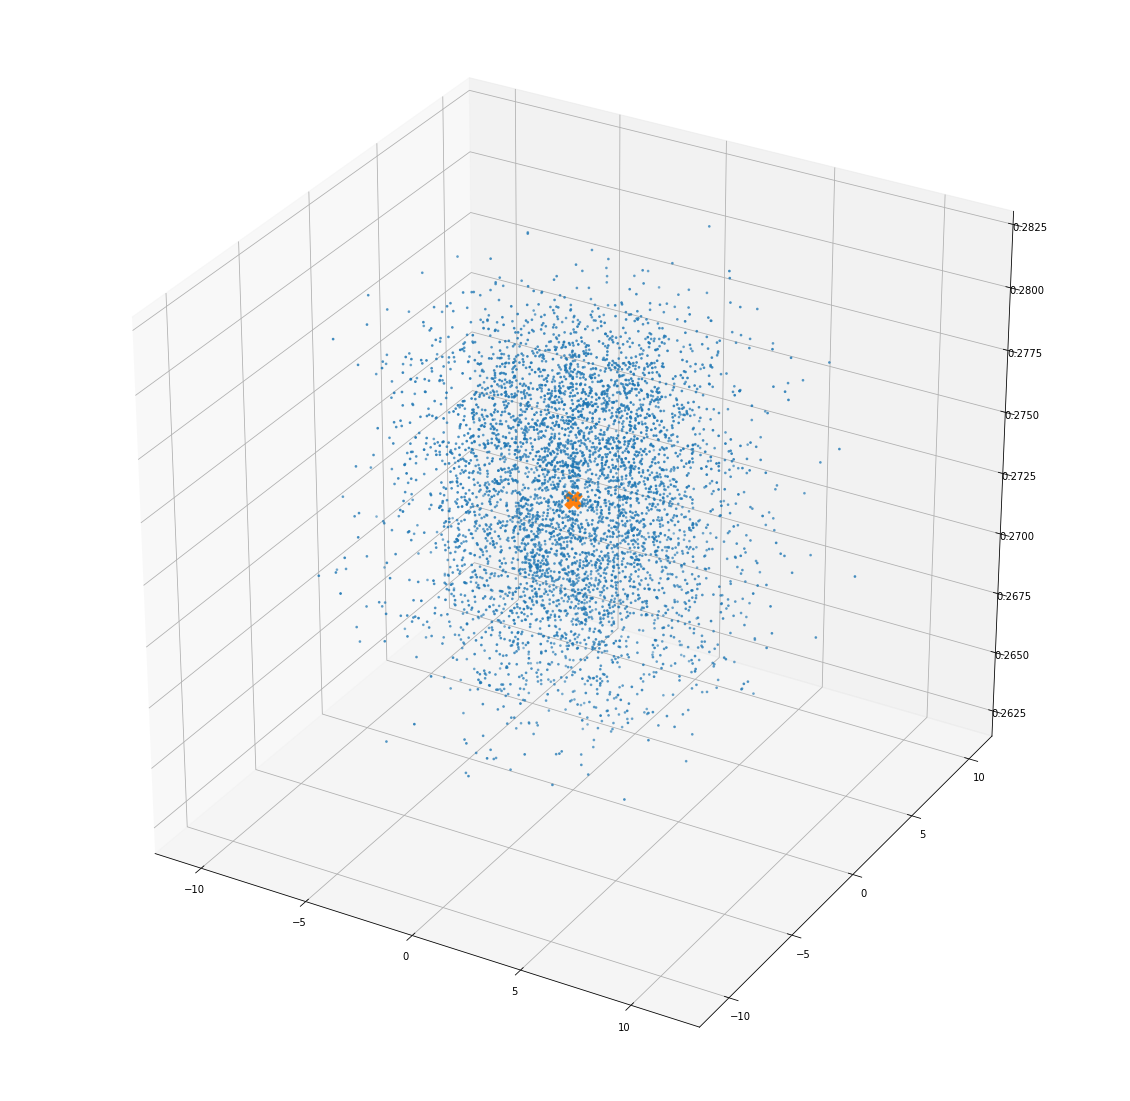

In [71]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')
ax.scatter(t_angle_x,t_angle_y, dists, marker="o",s=3)
ax.scatter(t_angle_x[0],t_angle_y[0], dists[0], marker="X",s=300)

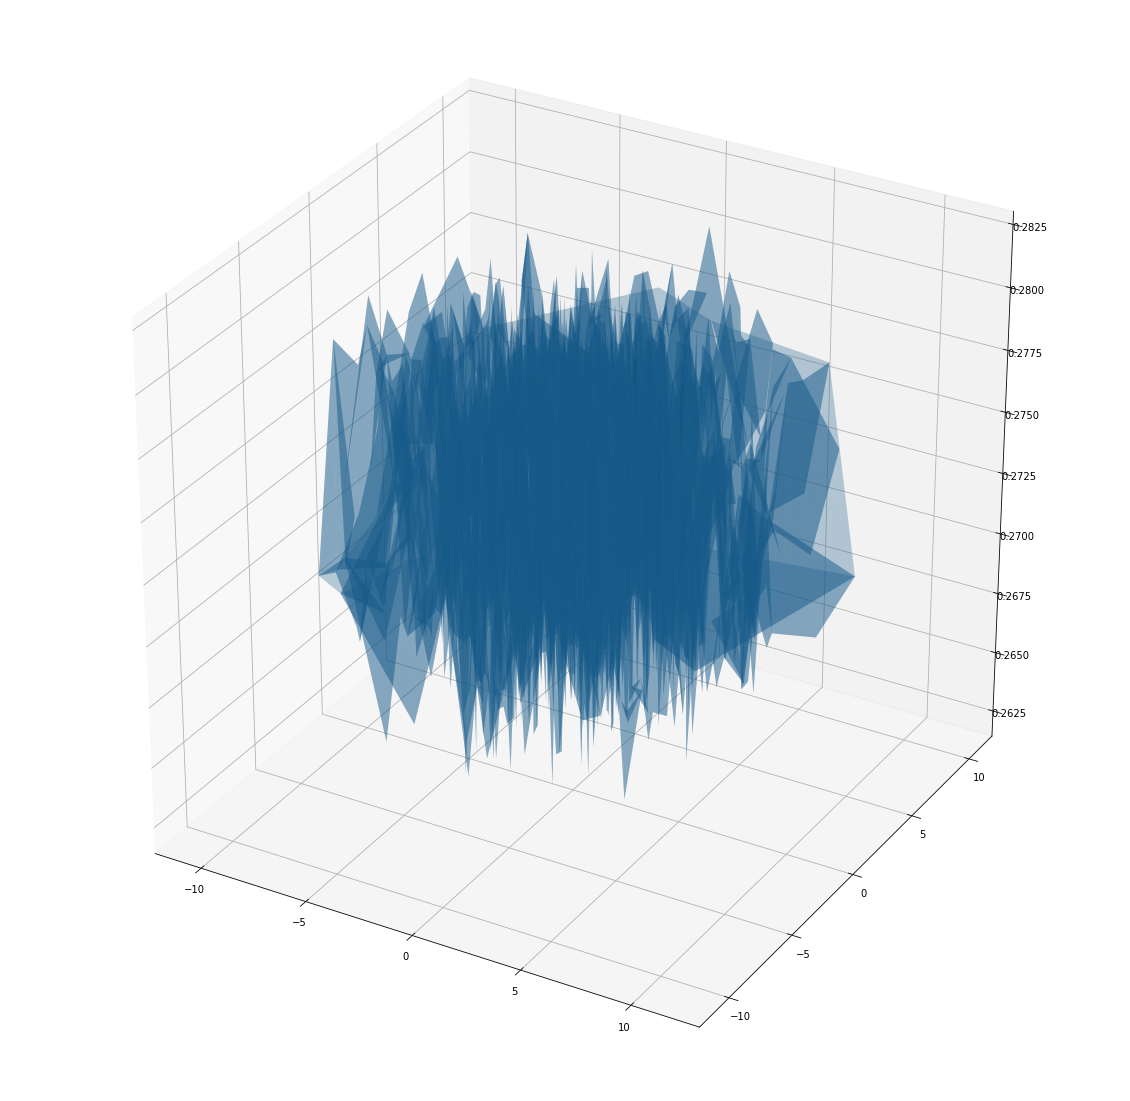

In [70]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(t_angle_x,t_angle_y, dists,alpha=0.3)
ax.scatter(t_angle_x[0],t_angle_y[0], dists[0], marker="X",s=300)